## OCO\_Data\_Read.ipynb

### Things that happen in this notebook:

1. Read in all the (Level 2 OCO2 Lite) data in B8100r folder (all of 2017), saving data frame as hdf file for future use (and so you don't have to read the individual csv files again since that takes a very long time)

2. Visualize soundings falling over California in terms of their XCO2 and total column water vapor (tcwv)

3. Determine the soundings that are available near Jasper Ridge, CA.


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset #oco2 data is netcdf, no it's actually h5...
import pandas as pd
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import pandas as pd
import datetime
from pathlib import Path
import glob, os

In [2]:
fname_all2017 = './all_lite_files_2017.hdf'
# read in the hdf frame if it exists, else, read in all the individual csv's
if Path(fname_all2017).exists():
    print('reading file ', fname_all2017)
    df = pd.read_hdf(fname_all2017,'mydata')
else:
    # list files in data/B100r
    files = []
    files = sorted(glob.glob("data/B8100r/*.nc4"))
    # Get all the data in the directory by appending NumPy arrays:
    # One day's worth of data:
    filename = files[0]

    data = Dataset(filename, mode='r')

    lat = data.variables['latitude'][:]
    lon = data.variables['longitude'][:]
    time = data.variables['time'][:]
    date = data.variables['date'][:]
    xco2 = data.variables['xco2'][:]
    tcwv = data.groups['Retrieval'].variables['tcwv'][:]
    sounding_id = data.variables['sounding_id'][:]

    data.close()

    # now iterate over rest of days:
    for f in files[1:]:
        # append another day...
        filename = f
        data = Dataset(filename, mode='r')
        lat = np.append(lat, data.variables['latitude'][:])
        lon = np.append(lon, data.variables['longitude'][:])
        time = np.append(time, data.variables['time'][:])
        date = np.append(date, data.variables['date'][:], axis=0)
        xco2 = np.append(xco2, data.variables['xco2'][:])
        tcwv = np.append(tcwv, data.groups['Retrieval'].variables['tcwv'][:])
        sounding_id = np.append(sounding_id, data.variables['sounding_id'][:])
        data.close()

    #make a data frame
    #data = Dataset(filename, mode='r')
    df = pd.DataFrame()
    df['lat'] = lat
    df['lon'] = lon
    df['time'] = time
    df['xco2'] = xco2
    df['tcwv'] = tcwv
    # convert 'time' to datetime
    df['datetime'] = df['time'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))
    df['sounding_id'] = sounding_id
    # the sounding_id column is 
    #16-digit number defined as YYYMMDDhhmmssmf.{YYYY=year,MM=month
    #1-12,DD=day1-31,hh=hour0-23,mm=minute0-59,ss=seconds0-59,
    #m=hundredsofmilliseconds0-9,f=footprintnumber1-8}.
    # so the final digit corresponds to the footbrint 1-8
    df['footprint'] = df['sounding_id'].astype(str).str[15].astype(int)
    df['year']      = df['sounding_id'].astype(str).str[:4].astype(int)
    df['month']     = df['sounding_id'].astype(str).str[4:6].astype(int)
    df['day']       = df['sounding_id'].astype(str).str[6:8].astype(int)
    df['hour']      = df['sounding_id'].astype(str).str[8:10].astype(int)
    df['minute']    = df['sounding_id'].astype(str).str[10:12].astype(int)
    df['second']    = df['sounding_id'].astype(str).str[12:14].astype(int)
    df['millisec'] = 100 * df['sounding_id'].astype(str).str[14].astype(int)
    # save pickle. actually pickles can't handle this much data, so try hdf
    print('saving file ', fname_all2017)
    df.to_hdf(fname_all2017,'mydata',mode='w')

reading file  ./all_lite_files_2017.hdf


In [3]:
df.head()

,lat,lon,time,xco2,tcwv,datetime,sounding_id,footprint,year,month,day,hour,minute,second,millisec
0,-84.680679,-148.495682,1.483246e+09,399.405334,3.893774,2017-01-01 04:43:09.562002,2017010104430971,1,2017,1,1,4,43,9,700
1,-84.694511,-148.810715,1.483246e+09,397.309662,3.807813,2017-01-01 04:43:09.922008,2017010104431002,2,2017,1,1,4,43,10,0
2,-84.667778,-149.063690,1.483246e+09,398.648346,3.906998,2017-01-01 04:43:10.561996,2017010104431071,1,2017,1,1,4,43,10,700
3,-84.685669,-149.186386,1.483246e+09,396.811401,3.822592,2017-01-01 04:43:10.588993,2017010104431072,2,2017,1,1,4,43,10,700
4,-84.663315,-149.250793,1.483246e+09,397.088837,3.907876,2017-01-01 04:43:10.896012,2017010104431101,1,2017,1,1,4,43,11,0


## Are all 8 footprints present in the dataset as a whole? Print the unique values found in the footprint column:

In [4]:
# what are all the unique values in the footprint column?
footprints_present = df.footprint.unique()
footprints_present

array([1, 2, 8, 4, 7, 5, 6, 3])

## All 8 values are present in the footprints column, so at least some of the time, we get a measurement for each of the 8 footprints.

## Scatter the OCO2 TCWV soundings just for the california region

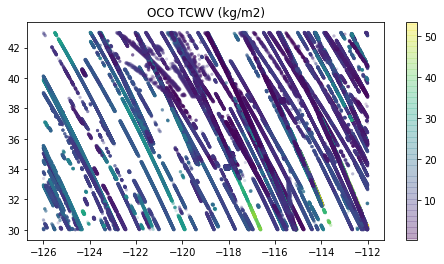

In [5]:
def scatter_latlon_box(df, left_lon=-126, right_lon=-112,
                      bottom_lat=30, top_lat=43):
    # subset dataframe
    d = df[(df['lat']>bottom_lat) & (df['lat']<top_lat) & (df['lon']> left_lon) & (df['lon']<right_lon)]
    plt.scatter(d['lon'], d['lat'], 10, d['tcwv'], edgecolors='none', alpha=0.2)
    fig = plt.gcf()
    fig.set_size_inches(16,10)
    plt.colorbar()
    plt.title("OCO TCWV (kg/m2)")
    fig = plt.gcf()
    fig.set_size_inches(8, 4)

scatter_latlon_box(df)

In [ ]:
scatter_latlon_map(df, field='xco2', fieldname='OCO XCO2 (ppm)')

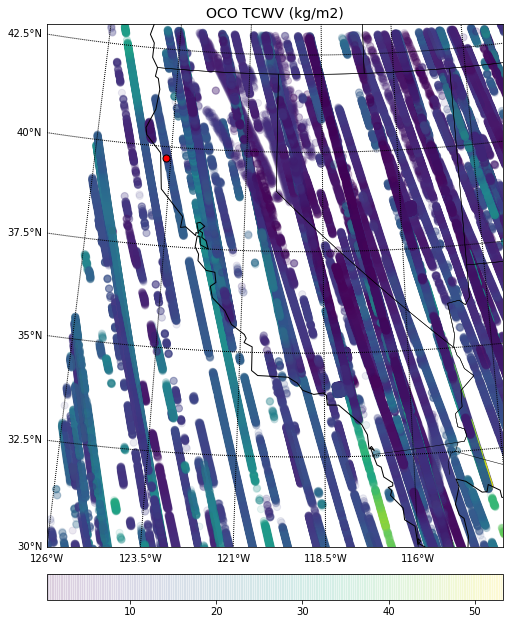

In [6]:
# plot on a map:
def scatter_latlon_map(df, field='tcwv', fieldname='OCO TCWV (kg/m2) ',
                       left_lon=-126, right_lon=-112,
                       bottom_lat=30, top_lat=43):
    """
    make a scatterplot (map) of tcwv for a lat-lon box
    inputs:
    df (Dataframe): a dataframe with columns lat, lon, and tcwv
    field (str): string corresponding to column you want for color/z axis (default tcwv, xco2 also works) 
    fieldname (str): pretty name of field you'd like to be in the title string
    left_lon, etc. (float or int): bounding values for lat lon box
    """
    # subset dataframe
    d = df[(df['lat']>bottom_lat) & (df['lat']<top_lat) & (df['lon']> left_lon) & (df['lon']<right_lon)]
    middle_lon = (left_lon + right_lon)/2.0
    middle_lat = (top_lat + bottom_lat)/2.0

    latcorners = d['lat']
    loncorners = d['lon']
    lon_0 = middle_lon
    lat_0 = middle_lat
    # create figure and axes instances
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # create polar stereographic Basemap instance.
    m = Basemap(projection='stere',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,\
                llcrnrlat=bottom_lat,urcrnrlat=top_lat,\
                llcrnrlon=left_lon,urcrnrlon=right_lon,\
                rsphere=6371200.,resolution='l',area_thresh=10000)

    m.drawcoastlines()
    m.drawstates()
    # draw parallels.
    m.drawcountries()
    parallels = np.arange(bottom_lat,top_lat,2.5)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(left_lon,right_lon,2.5)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    x, y = m(d['lon'].values,d['lat'].values)
    sct = m.scatter(x,y,50, d[field].values, marker='o', edgecolors=None, alpha=0.1)
    plt.title(fieldname, fontsize=14)
    cbar = m.colorbar(sct,location='bottom',pad="5%")
    fig = plt.gcf()
    fig.set_size_inches(15, 10)

    #add dot for angelo:
    CZO_lat = 39.72
    CZO_lon = -123.65
    X,Y = m(CZO_lon,CZO_lat)
    m.scatter(X,Y,50, marker='o', color='red', edgecolors='k')

scatter_latlon_map(df, field='tcwv', fieldname='OCO TCWV (kg/m2)')

In [12]:
df.dtypes

lat                   float32
lon                   float32
time                  float64
xco2                  float32
tcwv                  float32
datetime       datetime64[ns]
sounding_id            uint64
footprint               int64
year                    int64
month                   int64
day                     int64
hour                    int64
minute                  int64
second                  int64
millisec                int64
dtype: object

In [17]:
one_day = df[(df['datetime']>=datetime.datetime(2017,10,1)) & (df['datetime']<datetime.datetime(2017,10,2))]
one_day.head()

,lat,lon,time,xco2,tcwv,datetime,sounding_id,footprint,year,month,day,hour,minute,second,millisec
38774736,-73.156654,-149.899872,1.506818e+09,405.674286,0.480190,2017-10-01 00:33:53.030011,2017100100335306,6,2017,10,1,0,33,53,0
38774737,-73.149193,-150.070511,1.506818e+09,411.320129,0.504627,2017-10-01 00:33:53.082998,2017100100335308,8,2017,10,1,0,33,53,0
38774738,-73.135612,-150.001175,1.506818e+09,400.379547,0.471726,2017-10-01 00:33:53.390017,2017100100335337,7,2017,10,1,0,33,53,300
38774739,-73.114273,-150.103058,1.506818e+09,407.505646,0.484471,2017-10-01 00:33:53.750023,2017100100335378,8,2017,10,1,0,33,53,700
38774740,-73.104294,-149.949326,1.506818e+09,399.536530,0.467911,2017-10-01 00:33:54.030005,2017100100335406,6,2017,10,1,0,33,54,0


In [27]:
ten_days = df[(df['datetime']>= start_date) & (df['datetime']<end_date)]
ten_days.tail()

,lat,lon,time,xco2,tcwv,datetime,sounding_id,footprint,year,month,day,hour,minute,second,millisec
40056417,46.108006,6.668142,1.507639e+09,412.979736,12.854215,2017-10-10 12:34:48.029994,2017101012344806,6,2017,10,10,12,34,48,0
40056418,46.100365,6.677109,1.507639e+09,412.454742,14.092841,2017-10-10 12:34:48.056991,2017101012344807,7,2017,10,10,12,34,48,0
40056419,46.092628,6.685906,1.507639e+09,406.354950,14.724880,2017-10-10 12:34:48.083021,2017101012344808,8,2017,10,10,12,34,48,0
40056420,46.120205,6.669814,1.507639e+09,401.718933,10.776737,2017-10-10 12:34:48.390000,2017101012344837,7,2017,10,10,12,34,48,300
40056421,46.112473,6.678616,1.507639e+09,407.816345,11.553852,2017-10-10 12:34:48.416996,2017101012344838,8,2017,10,10,12,34,48,300


In [34]:
max(ten_days.lon)

179.99959

In [48]:
np.arange(-10, 10, 2)

array([-10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8])

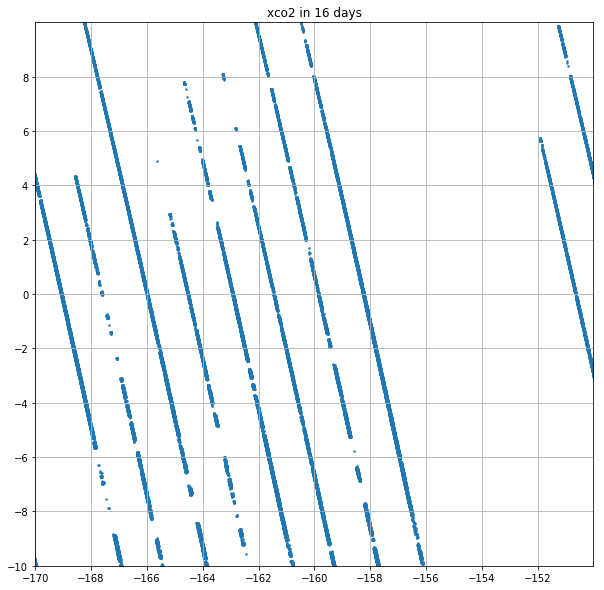

In [4]:
D = [1, 2, 4, 8, 16]
for duration_days in D:
    plt.clf()
    #duration_days = 10

    start_date = datetime.datetime(2017,10,1)
    end_date = start_date + datetime.timedelta(days=duration_days)
    partial_df = df[(df['datetime']>= start_date) & (df['datetime']<end_date)]


    # Major ticks every 20, minor ticks every 5
    yticks = np.arange(-10, 10, 2)
    xticks = np.arange(-170, -150, 2)

    plt.scatter(partial_df.lon, partial_df.lat, 2)
    plt.grid(True)
    plt.xlim([-170, -150])
    plt.ylim([-10,10])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(yticks)
    plt.title('xco2 in ' + str(duration_days) + ' days')
    plt.gcf().set_size_inches(10,10)

    name_to_save = '/Users/stephanie/projects/OCO2-TPW/count_maps/'+'obs_in_' + str(duration_days) + '_days.png'
    plt.savefig(name_to_save)


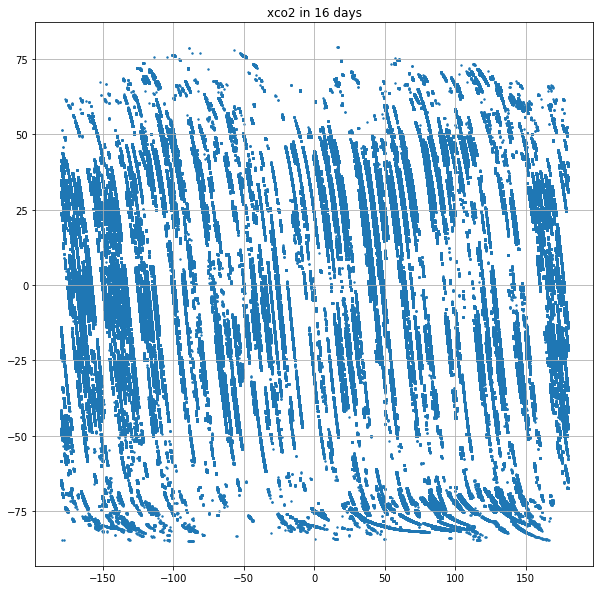

In [5]:
D = [1, 2, 4, 8, 16]
for duration_days in D:
    plt.clf()
    #duration_days = 10

    start_date = datetime.datetime(2017,10,1)
    end_date = start_date + datetime.timedelta(days=duration_days)
    partial_df = df[(df['datetime']>= start_date) & (df['datetime']<end_date)]


    # Major ticks every 20, minor ticks every 5
    #yticks = np.arange(-10, 10, 2)
    #xticks = np.arange(-170, -150, 2)

    plt.scatter(partial_df.lon, partial_df.lat, 2)
    plt.grid(True)
    #plt.xlim([-170, -150])
    #plt.ylim([-10,10])
    #plt.gca().set_xticks(xticks)
    #plt.gca().set_yticks(yticks)
    plt.title('xco2 in ' + str(duration_days) + ' days')
    plt.gcf().set_size_inches(10,10)

    name_to_save = '/Users/stephanie/projects/OCO2-TPW/count_maps/'+'obs_in_' + str(duration_days) + '_days_Global.png'
    plt.savefig(name_to_save)

## Jasper Ridge Observations

### Katelyn wants to find soundings near Jasper Ridge. The following cell subsets the data frame for the region near that point. You can see that for any given time (e.g., looking at measurements for the same hundreds-of-milliseconds), some subset of the 8 footprints is available. If one or more of the 8 footprints is missing for a given time, there are a couple potential explanations:
1. No sounding converged for that particular footprint
2. Somehow the measurement for that particular footprint got left out of this data product -- the lite data is bias-corrected, but it might also filter out for footprints that are too different from the rest of the footprints -- check the documentation here:
https://docserver.gesdisc.eosdis.nasa.gov/public/project/OCO/OCO2_XCO2_Lite_Files_and_Bias_Correction.pdf

### I suggest for next steps:
1. reading the documentation for the lite files, and maybe emailing someone who worked on creating the Lite data product if you still have questions
2. maybe getting the full (standard) data files instead of the lite to see if the full product has more of the footprints available more often

In [8]:
# zoom in on the bay area
left_lon = -122.13 - .04
right_lon = -122.13 + .04
top_lat = 37.297 + .027
bottom_lat = 37.297 - .025

df[(df['lat']>bottom_lat) & (df['lat']<top_lat) & 
   (df['lon']> left_lon) & (df['lon']<right_lon)].drop(['time','datetime','sounding_id'], axis=1)

,lat,lon,xco2,tcwv,footprint,year,month,day,hour,minute,second,millisec
26203947,37.278500,-122.128708,405.450500,22.257648,1,2017,5,31,21,12,0,300
26203955,37.296772,-122.135170,409.151001,22.854490,1,2017,5,31,21,12,0,700
26203956,37.286655,-122.132393,404.928711,22.832441,2,2017,5,31,21,12,0,700
26203957,37.276707,-122.129402,406.206604,22.043880,3,2017,5,31,21,12,0,700
26203963,37.315578,-122.140770,408.443939,21.362051,1,2017,5,31,21,12,1,0
26203964,37.305431,-122.138031,409.064026,21.886005,2,2017,5,31,21,12,1,0
26203965,37.294777,-122.136055,407.840057,22.934256,3,2017,5,31,21,12,1,0
26203966,37.284767,-122.133194,404.434021,22.577372,4,2017,5,31,21,12,1,0
26203967,37.274857,-122.130455,405.198944,21.662773,5,2017,5,31,21,12,1,0
26203972,37.323868,-122.144157,406.676575,21.320597,2,2017,5,31,21,12,1,300
